In [1]:
import numpy as np
import pandas as pd 
import os
from used_func import save_fig
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12


In [2]:
stocks=pd.read_csv('./datasets/question1_stocks.csv')
markets=pd.read_csv('./datasets/question1_market.csv')
markets=markets[markets['Markettype']==5].drop('Markettype',axis=1)
market_date=markets.date.str.rsplit('-',n=1,expand=True)
market_date.columns=['year','week']
market_date['year_or']=market_date.year.str.isnumeric()
markets=pd.concat([markets,market_date],axis=1)
markets=markets[markets.year_or==1].drop(['year','week','year_or'],axis=1).reset_index(drop=True)

stocks_date=stocks.date.str.rsplit("-",n=1,expand=True)
stocks_date.columns=['year','week']
stocks_date['year_or']=stocks_date.year.str.isnumeric()
stocks=pd.concat([stocks,stocks_date],axis=1)
stocks=stocks[stocks.year_or==1].drop(['year','week','year_or'],axis=1).reset_index(drop=True)

markets=markets.set_index('date')
mar_part1=markets.loc[:'2017-25']
mar_part2=markets.loc['2017-25':'2018-39']
mar_part3=markets.loc['2018-39':]

def stock_date_split(x):
    x=x.set_index('date')
    x['sign']=1
    x.loc['2017-25':'2018-39','sign']=2
    x.loc['2018-39':,'sign']=3
    return x

stocks=stocks.groupby('permno').apply(stock_date_split).drop('permno',axis=1).reset_index()
stock_part1=stocks[stocks.sign==1].drop('sign',axis=1).reset_index(drop=True)
stock_part2=stocks[stocks.sign==2].drop('sign',axis=1).reset_index(drop=True)
stock_part3=stocks[stocks.sign==3].drop('sign',axis=1).reset_index(drop=True)

part1=pd.merge(mar_part1,stock_part1,left_on='date',right_on='date',how='left')
part2=pd.merge(mar_part2,stock_part2,left_on='date',right_on='date',how='left')
part3=pd.merge(mar_part3,stock_part3,left_on='date',right_on='date',how='left')


part1=part1.dropna()
part2=part2.dropna()
part3=part3.dropna()


def check_number(x):
    if x.shape[0]<=10:
        x['num']=False
    else:
        x['num']=True
    return x
part1=part1.groupby('permno').apply(check_number)
part1=part1.query('num==1')


In [3]:
def value_reg_sum(df):
    df=df[['value_weighted_return','return']]
    x=df['value_weighted_return']
    X = sm.add_constant(x)
    y=df['return']
    model = sm.OLS(y, X)
    results = model.fit()
    param=results.params
    alpha=param.iloc[0]
    beta=param.iloc[1]
    tvalues=results.tvalues
    alpha_t=tvalues.iloc[0]
    beta_t=tvalues.iloc[1]
    pvalues=results.pvalues
    alpha_p=pvalues.iloc[0]
    beta_p=pvalues.iloc[1]
    R_sq=results.rsquared
    df=pd.Series({'alpha':alpha,'alpha_t':alpha_t,'alpha_p':alpha_p,
    'beta':beta,'beta_t':beta_t,'beta_p':beta_p,'R^2':R_sq})
    return df

part1=part1.groupby('permno').apply(value_reg_sum).reset_index()

In [4]:
part1.to_csv('./result_data/part1_capm.csv',index=False)
part1=pd.read_csv('./result_data/part1_capm.csv')
part1=part1.sort_values('beta',ascending=False).reset_index(drop=True)


## 每12个一组

In [5]:
part1['assign']=1
for i in range(1,251):
    part1['assign'][i*12:(i+1)*12]=(i+1)


In [6]:
group_assign=part1[['permno','assign']]
part2=pd.merge(group_assign,part2,on='permno',how='left')


In [7]:
part2=part2.groupby('permno').apply(check_number)
part2=part2.query('num==1')
part2=part2.dropna()


In [8]:
part2=part2.groupby(['assign','date']).agg({'value_weighted_return':np.mean,'return':np.mean}).reset_index()


In [9]:
part2=part2.groupby('assign').apply(value_reg_sum).reset_index()


In [10]:
part2.to_csv('./result_data/part2_capm.csv',index=False)


In [11]:
part3=pd.merge(group_assign,part3,on='permno',how='left')
part3=part3.groupby('permno').apply(check_number)
part3=part3.query('num==1')
part3=part3.dropna()


In [12]:
part3=part3.groupby('assign').agg({'value_weighted_return':np.mean,'return':np.mean}).reset_index()


In [13]:
df=part3[['value_weighted_return','return']]
x=df['value_weighted_return']
X = sm.add_constant(x)
y=df['return']
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.001840
Date:                Fri, 10 Apr 2020   Prob (F-statistic):              0.966
Time:                        13:30:11   Log-Likelihood:                 1203.0
No. Observations:                 251   AIC:                            -2402.
Df Residuals:                     249   BIC:                            -2395.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0025      0.004     -0.601      0.549      -0.011       0.006
value_weighted_return    -0.0842      1.963     -0.043      0.966      -3.950       3.781
==============================================================================
Omnibus:                       11.242   Durbin-Watson:                   1.583
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               24.773
Skew:                           0.032   Prob(JB):                     4.17e-06
Kurtosis:                       4.538   Cond. No.                     1.54e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.54e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[(-0.009, 0.007), (-0.0025, -0.0017)]

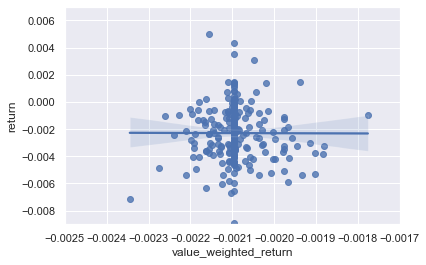

In [14]:
import seaborn as sns; sns.set(color_codes=True)
ax = sns.regplot(x="value_weighted_return", y="return", data=part3)
ax.set(xlim=(-0.0025,-0.0017),ylim=(-0.009,0.007))
